In [25]:
modelo = Modelo()
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [26]:
def validacao(modelo, validador, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # output do modelo em escala logarítmica
            ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu
            etiqueta_certa = etiquetas.numpy()[i]
            if (etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1
    print("Total de imgens testadas = ", conta_todas)
    print("\nPrecisão do modelo - {}%".format(conta_corretas*100/conta_todas))

In [27]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a politica de atualizacao dos pesos e da baias
    inicio = time() # timer para sabermos quanto tempo levou o treinamento

    criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
    EPOCHS = 10 # numero de epochs que o algoritmo rodara OBS: ideal o valor ser no minimo 100 para um bom treinamento
    modelo.train() # ativando o modelo de treinamento

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens "vetores" de 28*28 para vetores de 784
            otimizador.zero_grad() # zerando os gadientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

            perda_instantanea.backward() # propagando a partir da perda instantânea

            otimizador.step() # atualizando os pesos e as baias do modelo

            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada
        else:
            print("Epoch {} - Perda: {}".format(epoch + 1, perda_acumulada / len(trainloader)))
    print("\nTempo de Treino (em minutos) = ", (time() - inicio) / 60) # tempo total de treinamento

In [28]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entradam 784 neuronios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neuronios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neuronios que se ligam a 10
        # para a camada de saida não é necessario definir nada pois só preciso pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada pra camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para camada de saída, neste caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [29]:
print(imagens[0].shape) # para mostrar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # para verificar o tamanho do tensor da etiqueta

torch.Size([1, 28, 28])
torch.Size([])


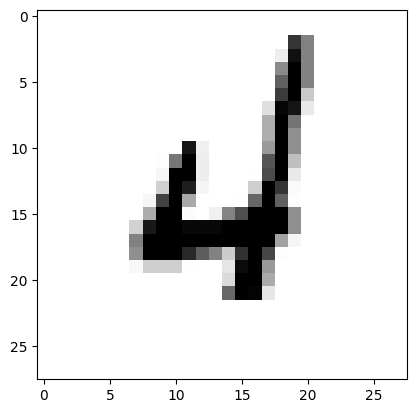

In [30]:
dataiter = iter(trainloader) #carraga da iteração do dataset
imagens, etiquetas = next(dataiter) #pega a próxima imagem e etiqueta do dataset
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r') #mostra a imagem

In [31]:
transform = transforms.ToTensor() # definindo a conversão  da imagem para tensor

trainset = datasets.MNIST('./MINST_data/', download=True, train=True, transform=transform)#Carraga a parte do treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)#Cria o buffer para pegar os dados do dataset

valset = datasets.MNIST('./MINST_data/', download=True, train=False, transform=transform)#Carrega a parte da validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)#Cria o buffer para pegar os dados do dataset

In [32]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
